## Question 2

Text(0, 0.5, 'Normalised Amplitude')

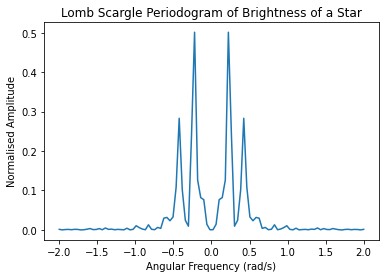

In [2]:
import pickle
import astropy.units as u
from astropy.timeseries import LombScargle
import numpy as np
import matplotlib.pyplot as plt
with open("/Users/admzlm4/Downloads/assignment2_gp.pkl", "rb") as fp:
     data = pickle.load(fp)
        
#Task 1 of Question 2 
import scipy.signal as signal
w = np.linspace(-2, 2, 100) #Array of angular frequencies over which to plot the logs
pgram = signal.lombscargle(data['t'], data['y'],w,normalize=True)


plt.plot(w, pgram)
plt.title('Lomb Scargle Periodogram of Brightness of a Star')
plt.xlabel('Angular Frequency (rad/s)')
plt.ylabel("Normalised Amplitude")
# Roughly symmetric with peaks at -0.5 rad/s, approximately -0.3, 0.3 and 0.5 rad/s



<ErrorbarContainer object of 3 artists>

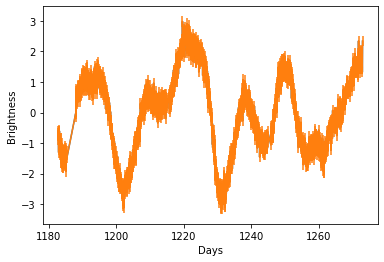

In [3]:
# Fitting the model to the data
from statsmodels.datasets import co2
import pandas as pd
data = pd.DataFrame(data)
plt.plot(data['t'], data['y'])
plt.xlabel('Days')
plt.ylabel('Brightness')
plt.errorbar(data['t'], data['y'], data['yerr'])

9.962031085009585
[ 2.17037902e-01  8.61671227e+01 -9.13604612e+00 -1.82740298e+00
 -2.36644597e+01  1.25492308e+02  6.57860738e+02  1.41915398e+02]
9.962031085009585
636.7089065085534


NameError: name 't' is not defined

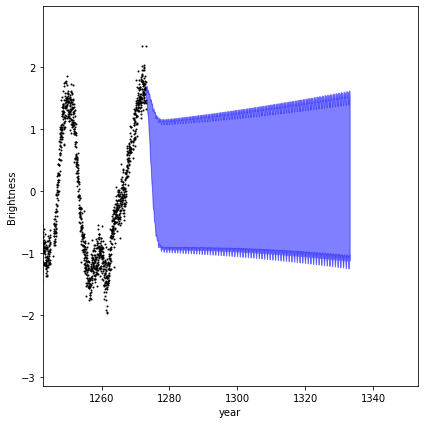

In [4]:
import george
from george import kernels
k1 = 66**2 * kernels.ExpSquaredKernel(metric=67**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(gamma=2/1.3**2, log_period=0.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2)
kernel = k2 + k4

gp = george.GP(kernel, mean=np.mean(data['y']), fit_mean=True,
               white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(data['t'])
print(gp.log_likelihood(data['y']))
print(gp.grad_log_likelihood(data['y']))

import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(data['y'], quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(data['y'], quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(data['t'])

# Print the initial ln-likelihood.
print(gp.log_likelihood(data['y']))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(data['y']))


x = np.linspace(max(data['t']), max(data['t'])+60, 2000)
mu, var = gp.predict(data['y'], x, return_var=True)
std = np.sqrt(var)
        
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(data['t'], data['y'], s=1, c="k")
ax.fill_between(x, mu+std, mu-std, color="b", alpha=0.5)
        
ax.set_xlim(data['t'].min()+60, data['t'].max()+80)
ax.set_ylim(data['y'].min(),data['y'].max())
ax.set_xlabel(r"year")
ax.set_ylabel(r"Brightness")
fig.tight_layout()


import emcee

def lnprob(p):
    # Trivial uniform prior.
    if np.any((-100 > p[1:]) + (p[1:] > 100)):
        return -np.inf

    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(y, quiet=True)
    
gp.compute(t)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 200)

print("Running production chain")
sampler.run_mcmc(p0, 200);

fig, ax = plt.subplots(figsize=(6, 6))

x = np.linspace(max(data['t']), 2025, 250)
for i in range(50):
    # Choose a random walker and step.
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(sampler.chain.shape[1])
    gp.set_parameter_vector(sampler.chain[w, n])

    # Plot a single sample.
    ax.plot(x, gp.sample_conditional(data['y'], data['t']), "g", alpha=0.1)

ax.scatter(data['t'], data['y'], c="k", s=1)

ax.set_xlim(data['t'].min(), 2025)
ax.set_xlabel(r"year")
ax.set_ylabel(r"CO$_2$ in ppm")
fig.tight_layout()